## Setup

In [ ]:
! brew install git python3 cmake sdl2 sdl2_image sdl2_ttf sdl2_gfx boost boost-python3
! python3 -m pip install --upgrade pip setuptools psutil wheel

In [ ]:
! pip install gfootball 

In [ ]:
! pip install setuptools==65.5.0
! git clone https://github.com/google-research/football.git
! cd football && pip install . 

### Test game play

In [127]:
! python -m gfootball.play_game --action_set=full

objc[81026]: Class SDLApplication is implemented in both /opt/homebrew/Cellar/sdl2/2.26.3/lib/libSDL2-2.0.0.dylib (0x106368800) and /Users/georgipachov/opt/miniconda3/envs/rl/lib/python3.10/site-packages/pygame/.dylibs/libSDL2-2.0.0.dylib (0x1321287e8). One of the two will be used. Which one is undefined.
objc[81026]: Class SDLAppDelegate is implemented in both /opt/homebrew/Cellar/sdl2/2.26.3/lib/libSDL2-2.0.0.dylib (0x106368850) and /Users/georgipachov/opt/miniconda3/envs/rl/lib/python3.10/site-packages/pygame/.dylibs/libSDL2-2.0.0.dylib (0x132128838). One of the two will be used. Which one is undefined.
objc[81026]: Class SDLTranslatorResponder is implemented in both /opt/homebrew/Cellar/sdl2/2.26.3/lib/libSDL2-2.0.0.dylib (0x1063688c8) and /Users/georgipachov/opt/miniconda3/envs/rl/lib/python3.10/site-packages/pygame/.dylibs/libSDL2-2.0.0.dylib (0x1321288b0). One of the two will be used. Which one is undefined.
objc[81026]: Class SDLMessageBoxPresenter is implemented in both /opt/h

### Learning environment 

In [3]:
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import gym
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import namedtuple
import gfootball
import gfootball.env as football_env
from gfootball.env.wrappers import Simple115StateWrapper
import collections

SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])
        
def obs_transform(obs):
    return Simple115StateWrapper.convert_observation(obs, True)


def create_env(render=False, 
               env_name='academy_empty_goal', 
               wrapper_init=None,
               record=True,
               **params):
    if env_name == 'cart_pole':
        env = gym.make('CartPole-v0')
    else:
        env_names = ['1_vs_1_easy', '5_vs_5', 'academy_run_to_score', 'academy_empty_goal_close', 'academy_empty_goal']
        os.environ['MESA_GL_VERSION_OVERRIDE'] = '3.3'
        env = football_env.create_environment(env_name=env_name, 
                                              stacked=False, 
                                              representation='raw',
                                              rewards='scoring,checkpoints',
                                              logdir='replays', 
                                              write_goal_dumps=record, 
                                              write_full_episode_dumps=record, 
                                              write_video=record,
                                              render=render)
        if wrapper_init is not None:
            return wrapper_init.__call__(env)
        else:
            return env


class Policy(nn.Module):
    """
    implements both actor and critic in one model
    """
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(115, 128)

        # actor's layer
        self.action_head = nn.Linear(128, 19)

        # critic's layer
        self.value_head = nn.Linear(128, 1)

        # action & reward buffer
        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        """
        forward of both actor and critic
        """
        x = F.relu(self.affine1(x))

        # actor: choses action to take from state s_t 
        # by returning probability of each action
        action_prob = F.softmax(self.action_head(x), dim=-1)

        # critic: evaluates being in the state s_t
        state_values = self.value_head(x)

        # return values for both actor and critic as a tuple of 2 values:
        # 1. a list with the probability of each action over the action space
        # 2. the value from state s_t 
        return action_prob, state_values


def select_action(model, state, in_training):
    state = torch.from_numpy(state).float()
    probs, state_value = model(state)

    # create a categorical distribution over the list of probabilities of actions
    m = Categorical(probs)

    # and sample an action using the distribution
    action = m.sample()

    return action.item(), SavedAction(m.log_prob(action), state_value)


def replay_episode_and_update(saved_actions, rewards, optimizer, gamma, finish=False, eps=1e-8):
    """
    Training code. Calculates actor and critic loss and performs backprop.
    """

    # reset gradients
    optimizer.zero_grad()

    R = 0
    policy_losses = [] # list to save actor (policy) loss
    value_losses = [] # list to save critic (value) loss
    returns = [] # list to save the true values
    # calculate the true value using rewards returned from the environment
    for r in rewards[::-1]:
        # calculate the discounted value
        R = r + gamma * R
        returns.insert(0, R)

    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()

        # calculate actor (policy) loss 
        policy_losses.append(-log_prob * advantage)

        # calculate critic (value) loss using L1 smooth loss
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))


    # sum up all the values of policy_losses and value_losses
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    # perform backprop
    loss.backward(retain_graph=finish)

    # Update weights
    optimizer.step()
            
    return torch.stack(policy_losses).sum().detach().numpy(),torch.stack(value_losses).sum().detach().numpy()


class DistanceFromOpponentGoalReward(gym.Wrapper):
        def __init__(self, env):
            super().__init__(env)
            self._env = env
        
        def step(self, action):
            obs, reward, done, info = self._env.step(action)
            reward = 0
            
            obs = obs[0]

            bx, by, bz = obs['ball']
            ogx, ogy = -1, 0
            
            dist_from_opponent_goal = (np.sqrt((bx-ogx)**2 + (by-ogy)**2))
            reward -= dist_from_opponent_goal
            
            return obs, reward, done, info
        

class DistanceFromOpponentGoalRewardFixed(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self._env = env
        self._last_ball_pos = [0, 0, 0]

    def step(self, action):
        obs, reward, done, info = self._env.step(action)
        reward = 0

        obs = obs[0]
        goals_left_team = obs['score'][0]
        if goals_left_team > 0:
            print('Goal discovered!')
            # reward += goals_left_team * 100_000
#         lost_ball = obs['ball_owned_team'] != -1
#         if lost_ball:
#             reward -=1

        bx, by, bz = obs['ball']
        ogx, ogy = 1+0.05, 0
        
        # Positive reward for distance from opponent players
        for i in range(len(obs['right_team'])):
            if obs['right_team_roles'][i] != 0: # 0 = goalkeeper:
                px, py = obs['right_team'][i]
                dist_from_ball = np.sqrt((bx-px)**2 + (by-py)**2)
                reward +=dist_from_ball
                
            # Force the team to avoid the ball going close to the goalkeeper
            elif obs['right_team_roles'][i] == 0: # 0 = goalkeeper:
                px, py = obs['right_team'][i]
                dist_from_ball = np.sqrt((bx-px)**2 + (by-py)**2)
                reward +=dist_from_ball*0.5

        # Negative reward for distance from opposition goal
        dist_from_opponent_goal = (np.sqrt((bx-ogx)**2 + (by-ogy)**2))
        reward -= dist_from_opponent_goal

        # Negative time penalty
        # reward -= 0.1
        
        # Positive ball velocity reward
        # Calculate ball velocity
        # velocity = np.sqrt(np.sum((obs['ball'] - self._last_ball_pos)**2))
        # reward += velocity

        self._last_ball_pos=obs['ball']
            
        return obs, reward, done, info
    
def run_agent(exp_name='exp1',
              model=None,
              train=True,
              replay_memory_goals=True,
              replay_memory_times=1,
              replay_memory_learning_rate=1e-2,
              render=False,
              record=False, 
              num_episodes=2000,
              num_steps=500,
              task='academy_empty_goal_close',
              wrapper_init=DistanceFromOpponentGoalReward,
              policy_fn=Policy,
              solved_threshold=-25,
              log_every=50,
              learning_rate=1e-2,
              gamma=0.99,
              last_n=5,
              seed=0,
              checkpoint=True,
              checkpoint_dir='checkpoints'
             ):
    # set seed first
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if not train:
        model.eval()
                
    if not os.path.exists(checkpoint_dir):
        os.mkdir(checkpoint_dir)
    
    try: 
        max_reward = -1_000_000
        running_reward = 0
        policy_losses = []
        critic_losses = []
        episodes_rewards = []
        env = create_env(render=render, 
                         env_name=task,
                         record=record,
                         wrapper_init=wrapper_init)
        if model is None:
            model = policy_fn()
            
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        # eps = np.finfo(np.float32).eps.item()
        eps = 1e-8
        
        saved_episodes = []
        for i_episode in range(num_episodes):
            # reset environment and episode reward
            episode_actions = []
            episode_states = []
            episode_rewards = []

            discard_episode = True
            
            # reset state
            state = env.reset()
            state = obs_transform(state)

            # play the episode
            for t in range(1, num_steps):
                # select action from policy
                action, savedAction = select_action(model, state, train)
                episode_actions.append(savedAction)

                # take the action
                state, reward, done, _ = env.step(action)
                
                if state['score'][0] > 0:
                    discard_episode = False
                
                state = obs_transform([state])
                episode_states.append(state)
                
                episode_rewards.append(reward)
                if done:
                    break

                    
            # log results
            ep_reward= np.sum(episode_rewards)
            episodes_rewards.append(ep_reward)
            
            # save episode if needed
            if not discard_episode:
                saved_episodes.append([episode_states, episode_actions, episode_rewards]) 
            
            # update cumulative reward
            running_reward = np.mean(episodes_rewards[-last_n:])
            
            if i_episode % log_every == 0:
                print(f'Episode: {i_episode}\tLast reward: {ep_reward:.2f} \t Last {last_n} episodes average reward: {running_reward}')

            if train:
                # save checkpoint
                if checkpoint:
                    if running_reward > max_reward:
                        torch.save(model, f'{checkpoint_dir}/{running_reward}_{task}_{exp_name}_checkpoint_{i_episode}.h5')
                        max_reward = running_reward

                if i_episode > last_n and running_reward > solved_threshold:
                    torch.save(model, f'{task}_{exp_name}.h5')
                    print('Solved!')
                    return model, episodes_rewards
                
                else:
                    # perform backprop
                    policy_loss, critic_loss = replay_episode_and_update(episode_actions, episode_rewards, optimizer, gamma, finish=True)
                    policy_losses.append(policy_loss)
                    critic_losses.append(critic_loss)
        
        
        if train and replay_memory_goals:
            # Replay best episodes once
            print(f'Replaying {replay_memory_times} times best {len(saved_episodes)} episodes with lr={replay_memory_learning_rate}...')
            
            optimizer = optim.Adam(model.parameters(), lr=replay_memory_learning_rate)
            for _ in range(replay_memory_times):
                for (states, actions, rewards) in saved_episodes:
                    env.reset()
                    episode_actions = []
                    episode_rewards = []
                    # play the episode
                    for t in range(1, num_steps):
                        state = states[t-1]
                        reward = rewards[t-1]

                        # select action from policy
                        action, savedAction = select_action(model, state, train)
                        episode_actions.append(savedAction)

                        # take the action
                        _, reward, done, __ = env.step(action)

                        episode_rewards.append(reward)
                        if done or t == len(states)-1:
                            break


                    # log results
                    ep_reward= np.sum(episode_rewards)
                    episodes_rewards.append(ep_reward)

                    # update cumulative reward
                    running_reward = np.mean(episodes_rewards[-last_n:])

                    if i_episode % log_every == 0:
                        print(f'Episode: {i_episode}\tLast reward: {ep_reward:.2f} \t Last {last_n} episodes average reward: {running_reward}')

                    # perform backprop
                    policy_loss, critic_loss = replay_episode_and_update(episode_actions, episode_rewards, optimizer, gamma, finish=True)
                    policy_losses.append(policy_loss)
                    critic_losses.append(critic_loss)
                    
        policy_losses = [p.reshape(-1)[0] for p in policy_losses]
        critic_losses = [p.reshape(-1)[0] for p in critic_losses]
        return model, episodes_rewards, policy_losses, critic_losses
    finally: 
        env.close()
        
def load_best_agent(checkpoints_dir='checkpoints'):
    # Load best agent
    checkpoints = os.listdir(checkpoints_dir)
    all_checkpoints = {int(x[:x.index('.')]):x for x in checkpoints}
    max_reward = max(all_checkpoints.keys())
    best = all_checkpoints[max_reward]
    print('Loading checkpoint: ', best)
    model_loaded = torch.load(os.path.join(checkpoints_dir, best))
    return model_loaded

def load_agent(name, checkpoints_dir='checkpoints'):
    # Load manually
    print('Loading checkpoint: ', name)
    model_loaded = torch.load(os.path.join(checkpoints_dir, name))
    return model_loaded

### Learning objective: 3 vs 1

Episode: 0	Last reward: -2.91 	 Last 10 episodes average reward: -2.913656551216802


/var/folders/4x/vb5tl80s45v2f_k7_zb004bc0000gn/T/ipykernel_24238/3757458203.py:126: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))


Goal discovered!
Goal discovered!
Goal discovered!
Goal discovered!
Episode: 100	Last reward: -2.96 	 Last 10 episodes average reward: -2.3453044293678342
Goal discovered!
Goal discovered!
Episode: 200	Last reward: -8.17 	 Last 10 episodes average reward: -4.2652091615769905
Goal discovered!
Episode: 300	Last reward: -3.32 	 Last 10 episodes average reward: -5.670878817154465
Episode: 400	Last reward: -3.33 	 Last 10 episodes average reward: -4.349159896527934
Episode: 500	Last reward: -6.51 	 Last 10 episodes average reward: -7.867843396698151
Episode: 600	Last reward: -3.31 	 Last 10 episodes average reward: -4.375658898240376
Episode: 700	Last reward: -3.31 	 Last 10 episodes average reward: -3.317602241297203
Episode: 800	Last reward: -3.31 	 Last 10 episodes average reward: -5.463232919739568
Episode: 900	Last reward: -3.33 	 Last 10 episodes average reward: -6.292512606265996
Episode: 1000	Last reward: -3.30 	 Last 10 episodes average reward: -4.65833857484598
Episode: 1100	Last 

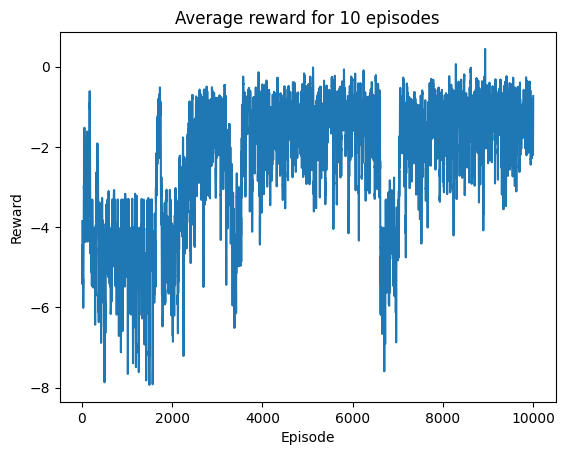

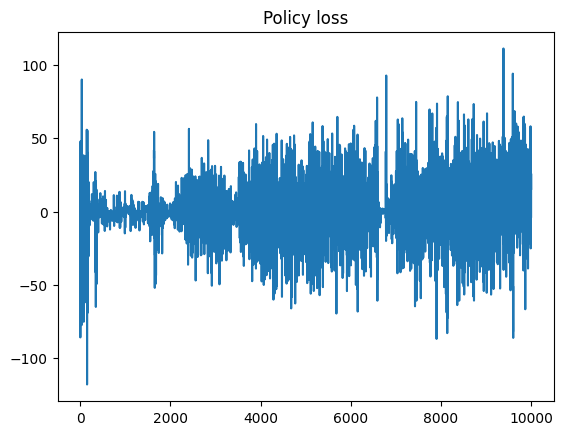

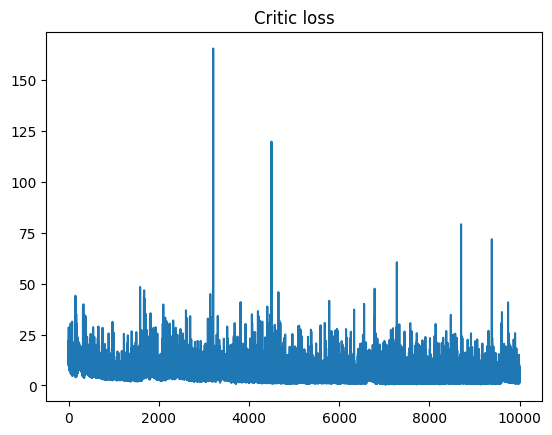

In [14]:
# Without replay memory
last_n=10
model, episode_rewards, policy_losses, critic_losses = run_agent(train=True,
                                   replay_memory_goals=False,
                                   render=False,
                                   record=False,
                                   log_every=100,
                                   num_steps=50,
                                   num_episodes=10000,
                                   seed=42,
                                   last_n=last_n,
                                   solved_threshold=20_000, 
                                   task='academy_3_vs_1_with_keeper', 
                                   learning_rate=5e-3,
                                   wrapper_init=DistanceFromOpponentGoalRewardFixed)

pd.Series(episode_rewards).rolling(last_n).mean().plot(xlabel='Еpisode', ylabel='Reward', title=f'Average reward for {last_n} episodes')
plt.show()
pd.Series(policy_losses).plot(title='Policy loss')
plt.show()
pd.Series(critic_losses).plot(title='Critic loss')
plt.show()

In [15]:
policy, er, _, __ = run_agent(model=model, 
          train=False, 
          render=False, 
          record=False,
          seed=0, 
          num_episodes=106,
          num_steps=100,
          task='academy_3_vs_1_with_keeper', 
          wrapper_init=DistanceFromOpponentGoalRewardFixed)

episodes_with_goals = len([e for e in er if e > 0])
print(f'Episodes with goals: {episodes_with_goals} from total {len(er)}')

Episode: 0	Last reward: -0.78 	 Last 5 episodes average reward: -0.780784511595958
Episode: 50	Last reward: -0.02 	 Last 5 episodes average reward: -1.346228520856568
Episode: 100	Last reward: -3.07 	 Last 5 episodes average reward: -2.484151479479838
Goal discovered!
Episodes with goals: 2 from total 106


In [13]:
policy, er, _, __ = run_agent(model=model, 
          train=False, 
          render=True, 
          record=True,
          seed=0, 
          num_episodes=106,
          num_steps=50,
          task='academy_3_vs_1_with_keeper', 
          wrapper_init=DistanceFromOpponentGoalRewardFixed)

episodes_with_goals = len([e for e in er if e > 0])
print(f'Episodes with goals: {episodes_with_goals} from total {len(er)}')

Episode: 0	Last reward: -7.59 	 Last 5 episodes average reward: -7.593694956913388
Episode: 50	Last reward: -1.01 	 Last 5 episodes average reward: -0.8807467722748916
Goal discovered!
Goal discovered!
Episode: 100	Last reward: -1.03 	 Last 5 episodes average reward: -2.307179947206086
Episodes with goals: 15 from total 106


In [61]:
# Save 6% goal rate
torch.save(model, '6_%_goal_rate_3_vs_1.h5')

In [ ]:
21

Episode: 0	Last reward: -0.67 	 Last 10 episodes average reward: -0.6658576409352165


/var/folders/4x/vb5tl80s45v2f_k7_zb004bc0000gn/T/ipykernel_93446/3812083269.py:126: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))


Episode: 100	Last reward: 1.02 	 Last 10 episodes average reward: -1.3308403465849203
Goal discovered!
Goal discovered!
Episode: 200	Last reward: -1.04 	 Last 10 episodes average reward: -1.2599184655498357
Goal discovered!
Goal discovered!
Goal discovered!
Episode: 300	Last reward: -2.31 	 Last 10 episodes average reward: 0.41856601235736546
Goal discovered!
Goal discovered!
Goal discovered!
Goal discovered!
Goal discovered!
Episode: 400	Last reward: 0.82 	 Last 10 episodes average reward: 0.1377020793550626
Episode: 500	Last reward: 3.60 	 Last 10 episodes average reward: 1.038842656304231
Goal discovered!
Goal discovered!
Episode: 600	Last reward: -0.02 	 Last 10 episodes average reward: -0.6389582454688588
Goal discovered!
Episode: 700	Last reward: 0.09 	 Last 10 episodes average reward: 0.12452028588912052
Goal discovered!
Goal discovered!
Goal discovered!
Goal discovered!
Episode: 800	Last reward: 0.04 	 Last 10 episodes average reward: 0.42610208602212474
Goal discovered!
Goal d

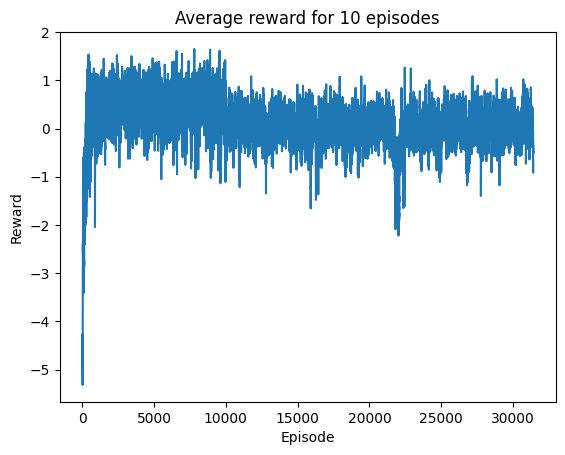

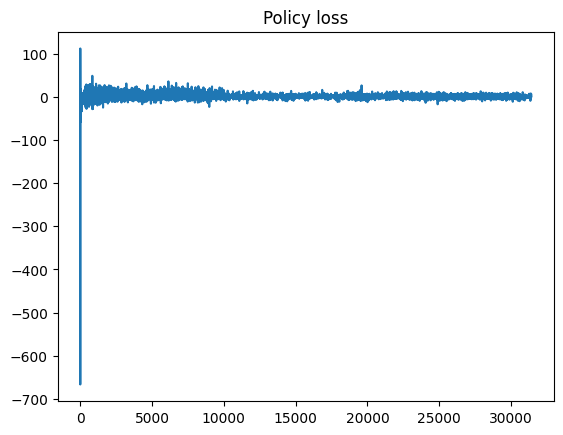

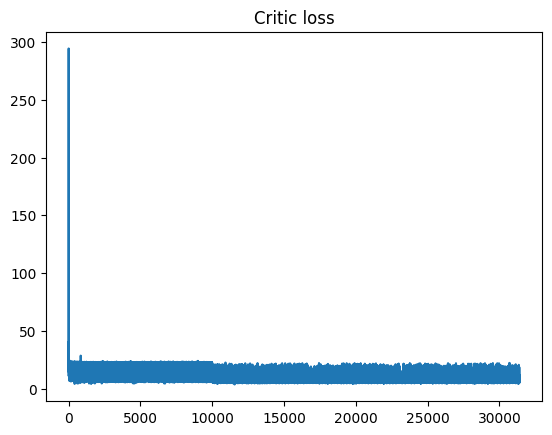

Episode: 0	Last reward: 0.15 	 Last 5 episodes average reward: 0.14875276259224485
Episode: 50	Last reward: 0.02 	 Last 5 episodes average reward: 0.18067725108682448
Goal discovered!
Goal discovered!
Goal discovered!
Goal discovered!
Episodes with goals: 62 from total 100


In [69]:
# With replay memory
last_n=10
model, episode_rewards, policy_losses, critic_losses = run_agent(train=True,
                                   replay_memory_goals=True,
                                   replay_memory_times=100,
                                   replay_memory_learning_rate=5e-2,
                                   render=False,
                                   record=False,
                                   log_every=100,
                                   num_steps=50,
                                   num_episodes=10_000,
                                   seed=42,
                                   last_n=last_n,
                                   solved_threshold=20_000, 
                                   task='academy_3_vs_1_with_keeper', 
                                   learning_rate=5e-2,
                                   wrapper_init=DistanceFromOpponentGoalRewardFixed)
pd.Series(episode_rewards).rolling(last_n).mean().plot(xlabel='Еpisode', ylabel='Reward', title=f'Average reward for {last_n} episodes')
plt.show()
pd.Series(policy_losses).plot(title='Policy loss')
plt.show()
pd.Series(critic_losses).plot(title='Critic loss')
plt.show()


policy, er, _, __ = run_agent(model=model, 
          train=False, 
          render=False, 
          record=False,
          seed=42, 
          num_episodes=100,
          num_steps=50,
          task='academy_3_vs_1_with_keeper', 
          wrapper_init=DistanceFromOpponentGoalRewardFixed)

episodes_with_goals = len([e for e in er if e > 0])
print(f'Episodes with goals: {episodes_with_goals} from total {len(er)}')

In [ ]:
policy, er, _, _ = run_agent(model=model, 
          train=False, 
          render=True, 
          record=True,
          seed=42, 
          num_episodes=500,
          num_steps=50,
          task='academy_3_vs_1_with_keeper', 
          wrapper_init=DistanceFromOpponentGoalRewardFixed)

episodes_with_goals = len([e for e in er if e > 0])
print(f'Episodes with goals: {episodes_with_goals} from total {len(er)}')

Episode: 0	Last reward: 0.82 	 Last 5 episodes average reward: 0.8151792591628941
